## Uncomment the following line to install dependencies in first run

In [1]:
# !pip install -U langgraph langsmith

## Create a *`StateGraph`*
- Start by creating a *`StateGraph`*. A *`StateGraph`* object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Message have type "list". The "add_message" function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list[str], add_messages]


graph_builder = StateGraph(State)

## Add a *`node`*
- Next add a "chatbot" node. **Nodes** represent units of work and are typically regular functions.

In [3]:
# !pip install -U "langchain[openai]"

In [4]:
# !pip install python-dotenv

In [5]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()

llm = init_chat_model(
        model=os.getenv("MODEL_NAME"),
        model_provider="openai",
        base_url = os.getenv("OPENAI_BASE_URL"),
        api_key = os.getenv("OPENAI_API_KEY")
    )

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the note is used.
graph_builder.add_node("chatbot", chatbot)

## Add and `entry` point
- Add an `entry` point to tell the graph **where to start its work** each time it is run:

In [7]:
graph_builder.add_edge(START, "chatbot")

## Add and `exit` point
- Add an `exit` point to indicate **where the graph should finish execution.** This is helpful for more complex flows, but even in a simple graph like this, adding an end node improves clarity.

In [8]:
graph_builder.add_edge("chatbot", END)

## Compile the graph
- Before running the graph, we'll need to compile it. We can do so by calling `compile()` on the graph builder. This creates a `CompiledGraph` we can invoke on our state.

In [9]:
graph = graph_builder.compile()

## Visualize the graph (optional)
- You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

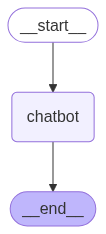

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

## Run the chatbot

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Okay, let's break down why oceans are blue. It's a surprisingly complex topic, and it's not as simple as "the ocean reflects the sky." Here's a detailed explanation, covering the main factors:

**1. Sunlight & the Spectrum of Colors**

*   **White Sunlight:** Sunlight appears white to us, but it's actually made up of all the colors of the rainbow (red, orange, yellow, green, blue, indigo, violet). You can see this when sunlight passes through a prism, or during a rain shower (creating a rainbow).
*   **Different Colors, Different Wavelengths:** Each color has a different wavelength.  Red and orange have longer wavelengths, while blue and violet have shorter wavelengths.

**2. Water's Interaction with Light - Absorption and Scattering**

*   **Absorption:** When sunlight hits the water, different colors are absorbed at different rates.  Here's the key:
    *   **Red, Orange, and Yellow:** These colors (longer wavelengths) are absorbed *very* quickly, especially in the upper l